# Exploratory Data Analysis on the Walmart Dataset

**The M5 dataset contains hierarchical sales data, generously made available by Walmart, starting at the item level and aggregating to that of departments, product categories and stores in three geographical areas of the US: California, Texas, and Wisconsin.**

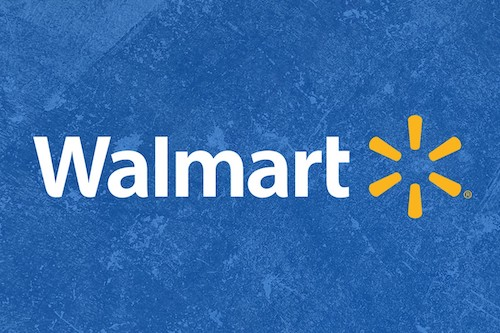

**In this notebook we are going to explore different features and time durations that plays an important role in the sale of the items across different stores. We will also try to cluster the stores_category that have similar sales.**

**Do upvote the notebook if you liked it!**

# Importing the Libraries

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
calendar = pd.read_csv('/kaggle/input/m5-forecasting-accuracy/calendar.csv')
sample_submission = pd.read_csv('/kaggle/input/m5-forecasting-accuracy/sample_submission.csv')
sell_prices = pd.read_csv('/kaggle/input/m5-forecasting-accuracy/sell_prices.csv')
sales_train_validation = pd.read_csv('/kaggle/input/m5-forecasting-accuracy/sales_train_validation.csv')
sales_train_evaluation = pd.read_csv('/kaggle/input/m5-forecasting-accuracy/sales_train_evaluation.csv')

In [ ]:
calendar.head(5)

**Do keep in mind that:**

**1 -> Saturday and 2 -> Sunday and so on**

In [ ]:
calendar['d'].unique()

* Calendar dataset contains columns like 'date', 'weekday', 'wday', 'month' and 'year' etc which basically indicates the overall duration across which this dataset was made.

* It also contains columns like 'event_name_1', 'event_name_2' which represents whether there was any holiday or event like christmas, father's day, etc that can lead to an increase in the sales of the items.

In [ ]:
sales_train_validation.head(5)

In [ ]:
sales_train_validation.shape

**From the sales_train_validation dataset given above we can observe that there are 30490 rows and 1919 columns, and if we observe the columns having 'd_' in it's name, we can conclude that sales data for 1913 days have been provided to us.**

In [ ]:
sales_train_validation['cat_id'].unique()

There are three different categories namely:
* Hobbies

* Household

* Foods

In [ ]:
sales_train_validation['dept_id'].unique()

**And within each categories, there are different departments. For example: for Hobbies category we have departments like Hobbies_1 and Hobbies_2. Similarly for Household and Foods categories.**

In [ ]:
sales_train_validation['state_id'].unique()

In [ ]:
sales_train_validation['store_id'].unique()

**The sales for three states: California, Texas and Wisconsin has been provided. And within each state, there are different stores for example: CA_1, CA_2, CA_3, and CA_4 in California.**

In [ ]:
sell_prices.head()

In [ ]:
sell_prices['item_id'].nunique()

**There are 3049 unique items**

In [ ]:
sales_train_validation['store_id'].value_counts()

And sales_train_validation contains the sales of each of these 3049 items in each store.

**This means sales_train_validation represents the sale of each item in 10 different stores (3049 * 10 = 30490) for 1913 days**

### Calendar

In [ ]:
import matplotlib.pyplot as plt 
def msv_1(data, thresh = 20, color = 'black', edgecolor = 'black', height = 3, width = 15):
    
    plt.figure(figsize = (width, height))
    percentage = (data.isnull().mean()) * 100
    percentage.sort_values(ascending = False).plot.bar(color = color, edgecolor = edgecolor)
    plt.axhline(y = thresh, color = 'r', linestyle = '-')
    
    plt.title('Missing values percentage per column', fontsize=20, weight='bold' )
    
    plt.text(len(data.isnull().sum()/len(data))/1.7, thresh+12.5, f'Columns with more than {thresh}% missing values', fontsize=12, color='crimson',
         ha='left' ,va='top')
    plt.text(len(data.isnull().sum()/len(data))/1.7, thresh - 5, f'Columns with less than {thresh}% missing values', fontsize=12, color='green',
         ha='left' ,va='top')
    plt.xlabel('Columns', size=15, weight='bold')
    plt.ylabel('Missing values percentage')
    plt.yticks(weight ='bold')
    
    return plt.show()
msv_1(calendar, 80, color=sns.color_palette('Reds',15))

We can observe that more than 80% of the values are missing for columns "event_name_2", "event_type_2", "event_name_1", "event_type_1". Therefore, we will remove thses columns.

In [ ]:
calendar.drop(["event_name_2", "event_type_2", "event_name_1", "event_type_1"], axis = 1, inplace = True)

In [ ]:
calendar.isnull().sum()

Now there are no null values in the dataset.

# Exploratory Data Analysis

In [ ]:
df = sales_train_validation

In [ ]:
df.head()

## Sales of Random Items

**Let's analyze the sales of a random item say: FOODS_3_090_CA_3_validation. This id means the sales of 'FOODS_3_090' item in the store 'CA_3'.**

In [ ]:
from itertools import cycle
import matplotlib.pyplot as plt

color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

dcols = [c for c in df.columns if 'd_' in c] ## Represents the days(d_1 -> d_1913)

df.loc[df['id'] == 'FOODS_3_090_CA_3_validation'].set_index('id')[dcols].T.plot(
figsize = (15, 5), title='FOODS_3_090_CA_3 sales by "d" number', color = next(color_cycle))
plt.show()

**We can see above that this particular item had quite a lot of days where the sales of the item was zero**

**We would also like to have the dates present on the x-axis instead of the day numbers, for that we will have to merge the sales_train_validation with the calendar dataset.**

In [ ]:
calendar[['d','date','wm_yr_wk', 'weekday', 'wday', 'month', 'year']].head()

In [ ]:
example = df.loc[df['id'] == 'FOODS_3_090_CA_3_validation'][dcols].T # Col name will be 8412
example = example.rename(columns={8412:'FOODS_3_090_CA_3'}) # Rename the column to FOODS_3_090_CA_3
example = example.reset_index().rename(columns={'index': 'd'}) # make the index d_1, d_2...d_1913
example = example.merge(calendar, how='left', validate='1:1')
example.head(5)

**Now we can observe above the sales of item 'FOODS_3_090_CA_3' for each date.**

In [ ]:
example.set_index('date')['FOODS_3_090_CA_3'] \
    .plot(figsize=(15, 5),
          color=next(color_cycle),
          title='FOODS_3_090_CA_3 sales by actual sale dates')
plt.show()

**Let's plot the sales for some more items say of HOBBIES_1_234_CA_3_validation and HOUSEHOLD_1_118_CA_3_validation**

In [ ]:
# Select more top selling examples
example2 = df.loc[df['id'] == 'HOBBIES_1_234_CA_3_validation'][dcols].T
example2 = example2.rename(columns={6324:'HOBBIES_1_234_CA_3'})
example2 = example2.reset_index().rename(columns={'index': 'd'}) 
example2 = example2.merge(calendar, how='left', validate='1:1')

example2.set_index('date')['HOBBIES_1_234_CA_3'] \
    .plot(figsize=(15, 5),
          color=next(color_cycle),
          title='HOBBIES_1_234_CA_3 sales by actual sale dates')
plt.show()

example3 = df.loc[df['id'] == 'HOUSEHOLD_1_118_CA_3_validation'][dcols].T
example3 = example3.rename(columns={6776:'HOUSEHOLD_1_118_CA_3'}) # Name it correctly
example3 = example3.reset_index().rename(columns={'index': 'd'}) # make the index "d"
example3 = example3.merge(calendar, how='left', validate='1:1')

example3.set_index('date')['HOUSEHOLD_1_118_CA_3'] \
    .plot(figsize=(15, 5),
          color=next(color_cycle),
          title='HOUSEHOLD_1_118_CA_3 sales by actual sale dates')
plt.show()

In [ ]:
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']

**Let's now examine the sales of the above 3 items and weekly, monthly and yearly level.**

In [ ]:
examples = ['FOODS_3_090_CA_3','HOBBIES_1_234_CA_3','HOUSEHOLD_1_118_CA_3']
example_df = [example, example2, example3]

for i in range(0, 3):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15, 3))
    
    example_df[i].groupby('wday').mean()[examples[i]].plot(
    kind = 'line', lw = 5, title = 'Average sale: day of the week', ax = ax1, 
        color = color_pal[0])
    
    example_df[i].groupby('month').mean()[examples[i]].plot(
    kind = 'line', lw = 5, title = 'Average sale: month of the year', ax = ax2, 
        color = color_pal[4])
    
    example_df[i].groupby('year').mean()[examples[i]].plot(
    kind = 'line', lw = 5, title = 'Average sale: year', ax = ax3, 
        color = color_pal[2])
plt.show()

* Its surprising that for the items "HOBBIES_1_234_CA_3", the sale is peaking on the 4th day, instead of Saturday and Sunday, because for rest of the items the average sales is highest for 1st and 2nd day and then goes down for the rest of the days.

* The sales of the item "HOUSEHOLD_1_118_CA_3" was very close to zero or was zero, maybe the sales of the product was discontinued.

* There was a constant rise in the sales of the item "HOBBIES_1_234_CA_3" till 2015, after that it went down drastically.

**Now let's randomly pick 20 more items and view their sales**

In [ ]:
twenty_examples = df.sample(20, random_state = 529).set_index('id')[dcols].T.merge(
calendar.set_index('d')['date'], left_index = True, right_index = True, validate = '1:1').set_index('date')

In [ ]:
fig, axs = plt.subplots(10, 2, figsize = (20, 20))
axs = axs.flatten()

ax_idx = 0

for item in twenty_examples.columns:
    twenty_examples[item].plot(
    title = item, color = next(color_cycle),
    ax = axs[ax_idx])
    ax_idx += 1
plt.tight_layout()
plt.show()

## Category

In [ ]:
df.groupby('cat_id').count()['id'].sort_values().plot(kind = 'barh', figsize=(15, 5), title='Count of Items by Category')
plt.show()

**As expected the sales of the FOODS items was the highest among the all categories**

In [ ]:
past_sales = df.set_index('id')[dcols].T.merge(calendar.set_index('d')['date'], left_index = True, right_index = True, validate = '1:1').set_index('date')

In [ ]:
past_sales.head(5)

**We have created a new table named as 'past_sales' having number of columns as 30490, that has been formed by merging of 'sales_train_validation' and 'calendar' so that we can view the sales of all items for each date.**

In [ ]:
for i in df['cat_id'].unique():
    items_col = [c for c in past_sales.columns if i in c]
    past_sales[items_col].sum(axis = 1).plot(figsize = (15, 5), alpha = 0.8, title = 'Total Sales by Item Type')
plt.legend(df['cat_id'].unique())
plt.show()

**The sales of the FOODS items is much much more than the HOUSEHOLD and HOBBIES category. You might be wondering why there is a certain dip in the sales for all the categories on a particular date, that's because it was a chritmas on those days.**

In [ ]:
store_list = sell_prices['store_id'].unique()
for s in store_list:
    store_items = [c for c in past_sales.columns if s in c]
    past_sales[store_items] \
        .sum(axis=1) \
        .rolling(90).mean() \
        .plot(figsize=(15, 5),
              alpha=0.8,
              title='Rolling 90 Day Average Total Sales (10 stores)')
plt.legend(store_list)
plt.show()
## Average sales of itmes in each store on 90 days average.

The sale was highest for CA_3 store

In [ ]:
fig, axes = plt.subplots(5, 2, figsize=(15, 10), sharex=True)
axes = axes.flatten()
ax_idx = 0
for s in store_list:
    store_items = [c for c in past_sales.columns if s in c]
    past_sales[store_items] \
        .sum(axis=1) \
        .rolling(7).mean() \
        .plot(alpha=1,
              ax=axes[ax_idx],
              title=s,
              lw=3,
              color=next(color_cycle))
    ax_idx += 1
# plt.legend(store_list)
plt.suptitle('Weekly Sale Trends by Store ID')
plt.tight_layout()
plt.show()

In [ ]:
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

greens = ["mediumaquamarine", "mediumseagreen", "seagreen", "green"]
store_list = sell_prices['store_id'].unique()
fig = go.Figure()
means = [] ## Mean sale of each store across all duration.
stores = [] ## Unique Store ids
for i, s in enumerate(store_list):
    if "ca" in s or "CA" in s:
        store_items = [c for c in past_sales.columns if s in c]
        data = past_sales[store_items].sum(axis=1).rolling(90).mean() ## Rolling 90 days average
        means.append(np.mean(past_sales[store_items].sum(axis=1)))
        stores.append(s)
        fig.add_trace(go.Scatter(x=np.arange(len(data)), y=data, name=s, marker=dict(color=greens[i])))
fig.update_layout(yaxis_title="Sales", xaxis_title="Time", title="Rolling Average Sales vs. Time (California)")

# Sales Distribution

In [ ]:
calendar1 = calendar[['date', 'weekday', 'wday', 'month', 'year']]

In [ ]:
calendar1.head()

In [ ]:
past_sales1 = past_sales.merge(calendar1.set_index('date'), left_index = True, right_index = True, validate = '1:1')

In [ ]:
past_sales1.head()

**past_sales1 represents the sales of all items for each date and containing the month, year, and wday as columns so that we can make some more slicing and dicing and analyze them**

## Store Level

In [ ]:
fig, axes = plt.subplots(5, 2, figsize=(15, 10), sharex=True)
axes = axes.flatten()
ax_idx = 0
stores = df['store_id'].unique()
for store in stores:
    store_items = [c for c in past_sales1.columns if store in c]
    past_sales1[store_items] \
        .sum(axis=1) \
        .plot(alpha=1,
              kind = "hist",
              ax=axes[ax_idx],
              title=store,
              lw=3,
              color=next(color_cycle))
    ax_idx += 1

plt.suptitle('Sales Trend according to Stores')
plt.tight_layout()
plt.show()

**We can see that the sales of the items follow a distribution that is very close to the normal distribution, therefore we can think of some methods like Power Transformation that can transform the distribution into a normal distributon.**

## Department Wise

In [ ]:
fig, axes = plt.subplots(4, 2, figsize=(15, 10), sharex=True)
axes = axes.flatten()
ax_idx = 0
depts = df['dept_id'].unique()
for dept in depts:
    dept_items = [c for c in past_sales1.columns if dept in c]
    past_sales1[dept_items] \
        .sum(axis=1) \
        .plot(alpha=1,
              kind = "hist",
              ax=axes[ax_idx],
              title=dept,
              lw=3,
              color=next(color_cycle))
    ax_idx += 1

plt.suptitle('Sales Trend according to Departments')
plt.tight_layout()
plt.show()

## Category Wise

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10), sharex=True)
axes = axes.flatten()
ax_idx = 0
cats = df['cat_id'].unique()
for cat in cats:
    cat_items = [c for c in past_sales1.columns if cat in c]
    past_sales1[cat_items] \
        .sum(axis=1) \
        .plot(alpha=1,
              kind = "hist",
              ax=axes[ax_idx],
              title=cat,
              lw=3,
              color=next(color_cycle))
    ax_idx += 1

plt.suptitle('Sales Trend according to Category')
plt.tight_layout()
plt.show()

## State Wise

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10), sharex=True)
axes = axes.flatten()
ax_idx = 0
states = df['state_id'].unique()
for state in states:
    state_items = [c for c in past_sales1.columns if state in c]
    past_sales1[state_items] \
        .sum(axis=1) \
        .plot(alpha=1,
              kind = "hist",
              ax=axes[ax_idx],
              title=state,
              lw=3,
              color=next(color_cycle))
    ax_idx += 1
# plt.legend(store_list)
plt.suptitle('Sales Trend according to States')
plt.tight_layout()
plt.show()

# Summers

**In US, June, July, and August are considered to be the summer months, therefore now we will aggregate data across these months.**

In [ ]:
salesSummer = past_sales1[(past_sales1['month'] == 6) | (past_sales1['month'] == 7) | (past_sales1['month'] == 8)]

#### By States

In [ ]:
states = df['state_id'].unique()
for state in states:
    cols = [c for c in salesSummer.columns if state in c]
    salesSummer[cols] \
        .sum(axis=1).plot(figsize=(15, 5),
              alpha=0.8,
              title='Sales of items state wise in Summers')
plt.legend(states)
plt.show()    

#### Category Wise

In [ ]:
categories = df['cat_id'].unique()
for cat in categories:
    cols = [c for c in salesSummer.columns if cat in c]
    salesSummer[cols] \
        .sum(axis=1).plot(figsize=(15, 5),
              alpha=0.8,
              title='Sales of items category wise in Summers')
plt.legend(categories)
plt.show()

#### Department Wise

In [ ]:
depts = df['dept_id'].unique()
for dept in depts:
    cols = [c for c in salesSummer.columns if dept in c]
    salesSummer[cols] \
        .sum(axis=1).plot(figsize=(15, 5),
              alpha=0.8,
              title='Sales of items Department wise in Summers')
plt.legend(depts)
plt.show()

**FOODS Category is the most sold product in Summers, and in particular FOODS_3 is sold the most, lets see it's distribution.**

#### FOOODS_3

In [ ]:
plt.hist(salesSummer[cols].sum(axis = 1))

It's very close to normal distribution.

# Sales during Christmas or in December

**Christmas is a festival where we would expect the sales of the items to be higher as compared to all other days as people tend to buy a lot of stuff for their home as well as for gifting purposes. In order to analyze the sales during Christmas, we will take into account the whole December.**

In [ ]:
salesChristmas = past_sales1[past_sales1['month'] == 12]

### State Wise

In [ ]:
states = df['state_id'].unique()
for state in states:
    cols = [c for c in salesChristmas.columns if state in c]
    salesChristmas[cols] \
        .sum(axis=1).plot(figsize=(15, 5),
              alpha=0.8,
              title='Sales of items state wise around Christmas')
plt.legend(states)
plt.show()    

### Category Wise

In [ ]:
categories = df['cat_id'].unique()
for cat in categories:
    cols = [c for c in salesChristmas.columns if cat in c]
    salesChristmas[cols] \
        .sum(axis=1).plot(figsize=(15, 5),
              alpha=0.8,
              title='Sales of items category wise during Christmas')
plt.legend(categories)
plt.show()

### Dept wise

In [ ]:
depts = df['dept_id'].unique()
for dept in depts:
    cols = [c for c in salesChristmas.columns if dept in c]
    salesChristmas[cols] \
        .sum(axis=1).plot(figsize=(15, 5),
              alpha=0.8,
              title='Sales of items Department wise during Christmas')
plt.legend(depts)
plt.show()

# Stores and Categories Clustering

**If we want to group together the stores according to the departments,we can club together the sales across stores for each category. Don't worry it will be clear going ahead.**

In [ ]:
df['store_id'].unique() ## These are all the stores.

In [ ]:
df['dept_id'].unique() ## These are all the departments.

In [ ]:
stores = df['store_id'].unique()
depts = df['dept_id'].unique()
a = []
concat = []
for store in stores:
    for dept in depts:
        concat.append(store+'_'+dept)
        cols = [c for c in past_sales1 if store in c and dept in c]
        a.append(past_sales1[cols].sum(axis=1).values)

In [ ]:
final = {}
for i in range(0, len(a)):
    final[concat[i]] = a[i]

In [ ]:
final.keys()

**This is the aggregation level we were talking about before, you can see that there are 70 keys formed by concatenating each store with each department i.e 10 (no of stores) * 7 (no of departments) = 70**


In [ ]:
store_dept = pd.DataFrame(final)
store_dept.head()

In [ ]:
store_dept['date'] = calendar['date']
store_dept['month'] = calendar['month']

In [ ]:
store_dept.head()

In [ ]:
store_dept['date'] = pd.to_datetime(store_dept['date'])

### Monthly Level

In [ ]:
month_level = pd.DataFrame()

In [ ]:
store_dept.head()

In [ ]:
def store_cat_month(month_level):
    for col in store_dept.drop(['date', 'month'], axis = 1).columns:
        month_level[col] = store_dept.resample('M', on='date')[col].sum().values
    return month_level

In [ ]:
month_level = store_cat_month(month_level)

In [ ]:
month_level = month_level.reset_index()

In [ ]:
month_level.rename(columns = {'index': 'Month_'}, inplace = True)
month_level['Month_'] += 1
month_level.head()

In [ ]:
month_level.shape

**Therefore, month_level represents the sales at a monthly level for 64 months.**

In [ ]:
month_level = month_level.T

In [ ]:
month_level.head()

In [ ]:
df.columns = df.iloc[0]
month_level.columns = month_level.iloc[0]
month_level.drop(month_level.index[0], inplace = True)

In [ ]:
month_level.head()

**As only 3 days(29, 30, 31) are included in the first month, we will drop the first column.**

In [ ]:
month_level.drop([1], axis = 1, inplace = True)

In [ ]:
month_level

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [ ]:
ss = StandardScaler()
features = ss.fit_transform(month_level)

In [ ]:
features

In [ ]:
kmeans_kwargs = {
       "init": "random",
       "n_init": 10,
        "max_iter": 300, }
# A list holds the SSE values for each k
sse = []
for k in range(1, 20):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(features)
    sse.append(kmeans.inertia_)

In [ ]:
plt.plot(range(1, 20), sse)
plt.xticks(range(1, 20))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

**Elbow method is a method that can be used for finding the right number of Clusters. By the look of the eye, it's difficult to judge the right cluster number, therefore we will use the 'kneed' library.**

In [ ]:
!pip install kneed

In [ ]:
from kneed import KneeLocator

In [ ]:
kl = KneeLocator(range(1, 20), sse, curve="convex", direction="decreasing")
kl.elbow

**4 is the right number of clusters to be used.**

### Using 4 Clusters

In [ ]:
kmeans = KMeans(n_clusters=4, **kmeans_kwargs)
kmeans.fit(features)

In [ ]:
cluster_map = pd.DataFrame()
cluster_map['data_index'] = month_level.index.values
cluster_map['cluster'] = kmeans.labels_

In [ ]:
cluster_map.head()

In [ ]:
unique_clusters = cluster_map['cluster'].unique()
clusters = {}
for cluster in unique_clusters:
    similar_indices = cluster_map[cluster_map['cluster'] == cluster]['data_index']
    clusters[cluster] = similar_indices
clusters.keys()

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(15, 5), sharey=True)
axes = axes.flatten()
ax_idx = 0
for key in clusters.keys():
    plt.axes(axes[ax_idx])
    cluster = clusters[key].values
    for i in range(0, len(cluster)):
        plt.plot(month_level.loc[cluster[i]],
                lw = 3,
            )
    ax_idx += 1
    plt.title("C" + str(key))
plt.suptitle('Sales according to cluster number')
plt.tight_layout()
plt.show()

**The cluters has been differentiated based on the total number of items sold, each cluster has varying sales, and different lowest and highest sales. For example: C0 has stores_cat that have sales in range 50k to 100k, in contrast C3 have store_cat having sales in the range 0 to 20k.**

**We can even view the stores_cat belonging to the clusters**

In [ ]:
clusters[0]

**Hope you liked the notebook, any suggestions would be highly appreciated.**

**I will continue experimenting in future versions of the notebook.**

**Please upvote if you liked it.**